In [1]:
import xarray as xr
import numpy as np
import numpy as np
import xarray as xr
import os
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

In [2]:
import os
import xarray as xr
import pandas as pd


def open_with_cftime(file_path, engine="netcdf4"):
    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    ds = xr.open_dataset(
        file_path,
        engine=engine,
        decode_times=time_coder
    )
    iso_times = ds['time'].dt.strftime('%Y-%m-%dT%H:%M:%S').values
    pd_times = pd.to_datetime(iso_times)
    return ds.assign_coords(time=pd_times)

In [16]:
def compute_weekly_climatology(file_list, variable=None):
    datasets = [open_with_cftime(fp) for fp in file_list if os.path.isfile(fp)]
    combined = xr.concat(datasets, dim='time', data_vars='minimal', coords='minimal')
    da = combined[variable] if variable else combined
    daily = da.resample(time='1D').sum(dim='time')
    daily = daily.assign_coords(weekofyear=daily['time'].dt.isocalendar().week)
    weekly_clim = daily.groupby('weekofyear').median(dim='time')
    # Sample 1 year
    #df = daily.to_dataframe().reset_index()
    #df['week'] = df['time'].dt.isocalendar().week
    #df['year'] = df['time'].dt.year
    #df['iso_year'] = df['time'].dt.isocalendar().year
    #df['dayofyear'] = df['time'].dt.dayofyear
    # Group and print
    #for week in sorted(df['week'].unique()):
        #sample = df[df['week'] == week]
        #print(f"Week {week:02d}: {sample['time'].min().date()} to {sample['time'].max().date()} ({len(sample)} days)")

    return weekly_clim, daily

In [4]:
def compute_daily_series(file_path, variable=None):
    ds = open_with_cftime(file_path)
    da = ds[variable] if variable else ds
    daily = da.resample(time='1D').sum(dim='time')
    return daily

In [5]:
def detect_droughts(daily, weekly_clim, min_run=2):
    """
    Detect drought events: runs of at least `min_run` consecutive days where daily < threshold,
    with threshold defined as 10% of the weekly mean daily energy.
    Returns:
      event_count    = number of events per grid cell
      mean_duration  = mean duration of events per grid cell
    """
    weeks = daily['time'].dt.isocalendar().week
    threshold = 0.1 * weekly_clim.sel(weekofyear=weeks)
    drought = daily < threshold

    template = drought.isel(time=0)
    event_count = xr.zeros_like(template)
    current = xr.zeros_like(template)
    durations = []

    nt = drought.sizes['time']
    for t in range(nt):
        mask = drought.isel(time=t)
        current = xr.where(mask, current + 1, 0)
        new_event = (current == min_run)
        event_count = event_count + new_event

        if t < nt - 1:
            next_mask = drought.isel(time=t+1)
            end_run = (~next_mask) & (current >= min_run)
        else:
            end_run = (current >= min_run)
        run_lengths = current.where(end_run)
        durations.append(run_lengths)

    if durations:
        # concatenate durations with override to ignore coordinate mismatches
        all_durs = xr.concat(durations, dim='event', compat='override')
        mean_duration = all_durs.mean(dim='event')
    else:
        mean_duration = xr.zeros_like(template)

    return event_count, mean_duration

In [6]:
# --- User parameters: adjust as needed ---
diri = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/"
models = [
    "ACCESS-CM2", "CanESM5", "CMCC-CM2-SR5", "CMCC-ESM2",
    "HadGEM3-GC31-LL", "HadGEM3-GC31-MM", "MRI-ESM2-0"
]
variable_name = "specific generation"

# Define periods and years
periods = {
    "BOC": {"subpath": "historical", "years": list(range(1980, 2015))},
    "EOC": {"subpath": "ssp585",    "years": list(range(2065, 2100))}
}



In [17]:
for model in models:
    for period, info in periods.items():
        base_dir = os.path.join(diri, f"{model}_1x1grid", info['subpath'])

        # Prepare file list for the whole period
        files = [os.path.join(base_dir, f"solar_power_{yr}.nc") for yr in info['years']]

        # Define output path
        output_dir = base_dir
        os.makedirs(output_dir, exist_ok=True)

        # Save weekly climatology
        filename = "daily_mean_per_week.nc"
        output_path = os.path.join(output_dir, filename)
        
        weekly_clim, daily = compute_weekly_climatology(files, variable=variable_name)

        if not os.path.isfile(output_path):
            weekly_clim.to_netcdf(output_path)
            print(f"Saved weekly climatology for {model} - {period}: {output_path}")
        else:
            print(f"File already exists, skipping weekly climatology: {output_path}")

        # Save daily time series by year
        for yr in info['years']:
            # Select only the data from the current year
            daily_year = daily.sel(time=str(yr))
            daily_output_path = os.path.join(output_dir, f"daily_solar_power_{yr}.nc")

            if not os.path.isfile(daily_output_path):
                daily_year.to_netcdf(daily_output_path)
                print(f"Saved daily solar power for {model} - {period} - {yr}: {daily_output_path}")
            else:
                print(f"File already exists, skipping daily data: {daily_output_path}")


File already exists, skipping weekly climatology: /work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/ACCESS-CM2_1x1grid/historical/daily_mean_per_week.nc
Saved daily solar power for ACCESS-CM2 - BOC - 1980: /work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/ACCESS-CM2_1x1grid/historical/daily_solar_power_1980.nc
Saved daily solar power for ACCESS-CM2 - BOC - 1981: /work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/ACCESS-CM2_1x1grid/historical/daily_solar_power_1981.nc
Saved daily solar power for ACCESS-CM2 - BOC - 1982: /work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/ACCESS-CM2_1x1grid/historical/daily_solar_power_1982.nc
Saved daily solar power for ACCESS-CM2 - BOC - 1983: /work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/ACCESS-CM2_1x1grid/historical/daily_solar_power_1983.nc
Saved daily solar power for ACCESS-CM2 - BOC - 1984: /work/users/s233224/Climate-Change-Imp

In [ ]:
file="/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/CMCC-CM2-SR5_1x1grid/historical/daily_mean_per_week.nc"
ds=xr.open_dataset(file, engine="netcdf4")
ds

<xarray.Dataset> Size: 816kB
Dimensions:              (x: 48, y: 40, weekofyear: 53)
Coordinates:
  * x                    (x) float64 384B -12.0 -11.0 -10.0 ... 33.0 34.0 35.0
    lon                  (x) float64 384B ...
  * y                    (y) float64 320B 33.0 34.0 35.0 36.0 ... 70.0 71.0 72.0
    lat                  (y) float64 320B ...
  * weekofyear           (weekofyear) int64 424B 1 2 3 4 5 6 ... 49 50 51 52 53
Data variables:
    specific generation  (weekofyear, y, x) float64 814kB ...

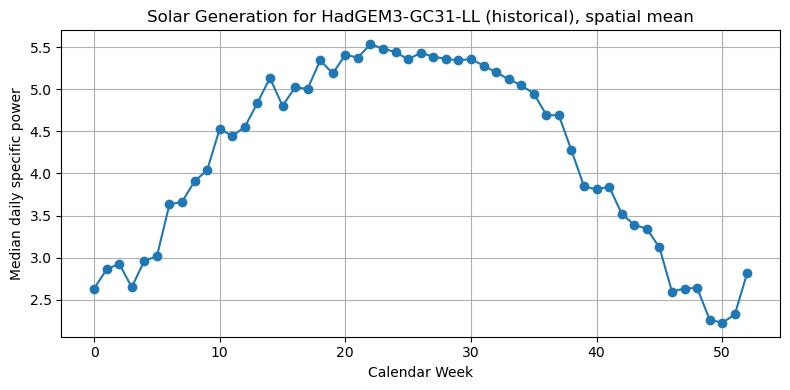

In [15]:
file="/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/HadGEM3-GC31-LL_1x1grid/historical/daily_mean_per_week.nc"
model="HadGEM3-GC31-LL"
period="historical"
ds=xr.open_dataset(file, engine="netcdf4")
p=ds['specific generation'].sel(y=41,x=2)
spatial_mean = ds['specific generation'].mean(dim=['y', 'x'])
plt.figure(figsize=(8, 4))
plt.plot(p, marker='o', linestyle='-')
plt.xlabel("Calendar Week")
plt.ylabel("Median daily specific power")
plt.title(f"Solar Generation for {model} ({period}), spatial mean")
plt.grid(True)
plt.tight_layout()
plt.show()



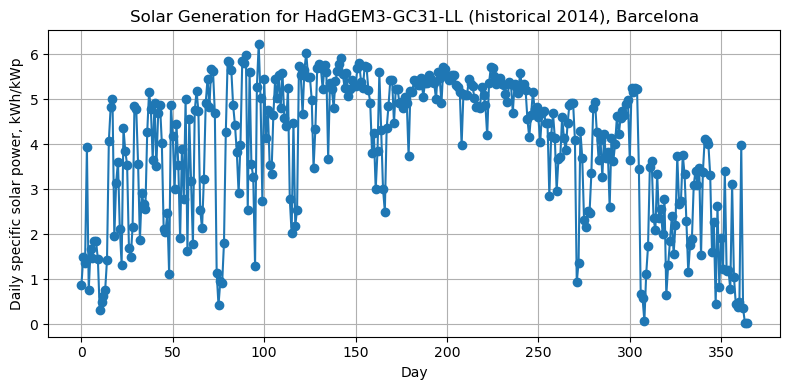

In [28]:
file="/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/HadGEM3-GC31-LL_1x1grid/historical/daily_solar_power_2014.nc"
model="HadGEM3-GC31-LL"
period="historical 2014"
ds=xr.open_dataset(file, engine="netcdf4")
p=ds['specific generation'].sel(y=41,x=2)
spatial_mean = ds['specific generation'].mean(dim=['y', 'x'])
plt.figure(figsize=(8, 4))
plt.plot(p, marker='o', linestyle='-')
plt.xlabel("Day")
plt.ylabel("Daily specific solar power, kWh/kWp")
plt.title(f"Solar Generation for {model} ({period}), Barcelona")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import os
import xarray as xr
import pandas as pd

drought_all = []
models = ["ACCESS-CM2", "CanESM5", "CMCC-CM2-SR5", "CMCC-ESM2","HadGEM3-GC31-LL", "HadGEM3-GC31-MM", "MRI-ESM2-0"]
#models=["MRI-ESM2-0"]

for model in models:
    for period, info in periods.items():
        base_dir = os.path.join(diri, f"{model}_1x1grid", info['subpath'])
        output_dir = base_dir

        # Load weekly climatology
        weekly_file = os.path.join(output_dir, "daily_mean_per_week.nc")
        if not os.path.isfile(weekly_file):
            print(f"Missing weekly climatology for {model} - {period}, skipping.")
            continue
        weekly_clim = xr.open_dataset(weekly_file)['specific generation']  # Adjust variable name if needed

        drought_summary = []

        import numpy as np

        for yr in info['years']:
            print(f"    ➤ Year: {yr}")
            daily_file = os.path.join(output_dir, f"daily_solar_power_{yr}.nc")

            # Load daily data: shape (time, y, x)
            daily_year = xr.open_dataset(daily_file)['specific generation']

            # Assign week number to each timestep
            weekofyear = daily_year['time'].dt.isocalendar().week
            daily_year = daily_year.assign_coords(weekofyear=('time', weekofyear.data))

            # Load weekly climatology: shape (weekofyear, y, x)
            weekly_clim = xr.open_dataset(weekly_file)['specific generation']

            # Compute 10% threshold
            threshold = weekly_clim * 0.2  # shape (weekofyear, y, x)

            # Match each day’s threshold via groupby
            daily_threshold = threshold.sel(weekofyear=daily_year['weekofyear'])

            # Identify drought days: element-wise comparison
            is_drought = daily_year < daily_threshold

            # Count total drought days per year, per grid cell
            drought_days = is_drought.sum(dim='time')

        # Identify drought events (runs of consecutive True values) per grid cell
            def drought_stats_1d(series):
                """Takes a 1D boolean array, returns:
                (#events, median_duration, max_duration, ≥5d events, ≥7d events, ≥10d events)
                """
                from itertools import groupby

                lengths = [sum(1 for _ in g) for k, g in groupby(series) if k]
                if not lengths:
                    return (0, 0.0, 0, 0, 0, 0)
                
                lengths = np.array(lengths)
                return (
                    len(lengths),
                    float(np.median(lengths)),
                    int(np.max(lengths)),
                    int(np.sum(lengths >= 5)),
                    int(np.sum(lengths >= 7)),
                    int(np.sum(lengths >= 10))
                )

            # Apply the function per grid cell
            event_stats = xr.apply_ufunc(
                drought_stats_1d,
                is_drought,
                input_core_dims=[['time']],
                output_core_dims=[[], [], [], [], [], []],
                vectorize=True,
                dask='parallelized',
                output_dtypes=[int, float, int, int, int, int],
            )

            # Save to file
            drought_output_file = os.path.join(output_dir, f"drought_stats_{yr}.nc")

            #if not os.path.isfile(drought_output_file):
            xr.Dataset({
                'drought_days': is_drought.sum(dim='time'),
                'drought_events': event_stats[0],
                'median_event_duration': event_stats[1],
                'max_event_duration': event_stats[2],
                'events_ge_5d': event_stats[3],
                'events_ge_7d': event_stats[4],
                'events_ge_10d': event_stats[5],
            }).to_netcdf(drought_output_file)

            print(f"    💾 Saved spatial drought stats to {drought_output_file}")
            #else:
                #print(f"    ⚠️ File already exists, skipping: {drought_output_file}")




    ➤ Year: 1980
    💾 Saved spatial drought stats to /work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/MRI-ESM2-0_1x1grid/historical/drought_stats_1980.nc
    ➤ Year: 1981
    💾 Saved spatial drought stats to /work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/MRI-ESM2-0_1x1grid/historical/drought_stats_1981.nc
    ➤ Year: 1982
    💾 Saved spatial drought stats to /work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/MRI-ESM2-0_1x1grid/historical/drought_stats_1982.nc
    ➤ Year: 1983
    💾 Saved spatial drought stats to /work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/MRI-ESM2-0_1x1grid/historical/drought_stats_1983.nc
    ➤ Year: 1984
    💾 Saved spatial drought stats to /work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/MRI-ESM2-0_1x1grid/historical/drought_stats_1984.nc
    ➤ Year: 1985
    💾 Saved spatial drought stats to /work/users/s233224/Climate-Change-Impacted-So

In [82]:
print(is_drought.sum().item(), "drought days in total")

63471 drought days in total


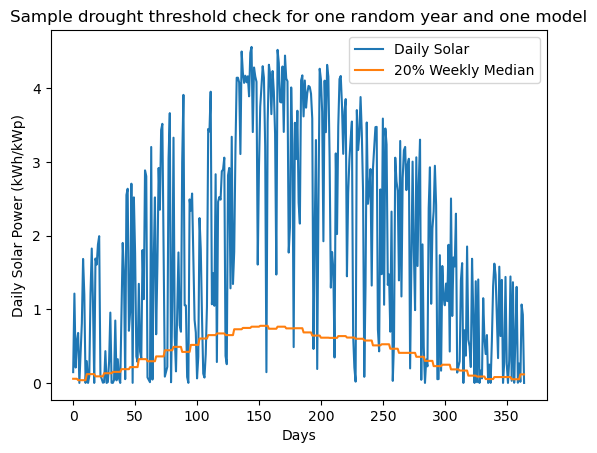

In [85]:
import matplotlib.pyplot as plt

i, j = 20, 5  # pick a sample y, x index

daily_series = daily_year[:, i, j]
threshold_series = daily_threshold[:, i, j]

plt.plot(daily_series, label="Daily Solar")
plt.plot(threshold_series, label="20% Weekly Median")
plt.legend()
plt.title("Sample drought threshold check for one random year and one model")
plt.xlabel("Days")
plt.ylabel("Daily Solar Power (kWh/kWp)")
plt.show()


In [97]:
path="/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/ACCESS-CM2_1x1grid/ssp585/drought_stats_2097.nc"
ds=xr.open_dataset(path, engine="netcdf4")
ds

<xarray.Dataset> Size: 109kB
Dimensions:                (x: 48, y: 40)
Coordinates:
  * x                      (x) float64 384B -12.0 -11.0 -10.0 ... 33.0 34.0 35.0
    lon                    (x) float64 384B ...
  * y                      (y) float64 320B 33.0 34.0 35.0 ... 70.0 71.0 72.0
    lat                    (y) float64 320B ...
Data variables:
    drought_days           (y, x) int64 15kB ...
    drought_events         (y, x) int64 15kB ...
    median_event_duration  (y, x) float64 15kB ...
    max_event_duration     (y, x) int64 15kB ...
    events_ge_5d           (y, x) int64 15kB ...
    events_ge_7d           (y, x) int64 15kB ...
    events_ge_10d          (y, x) int64 15kB ...

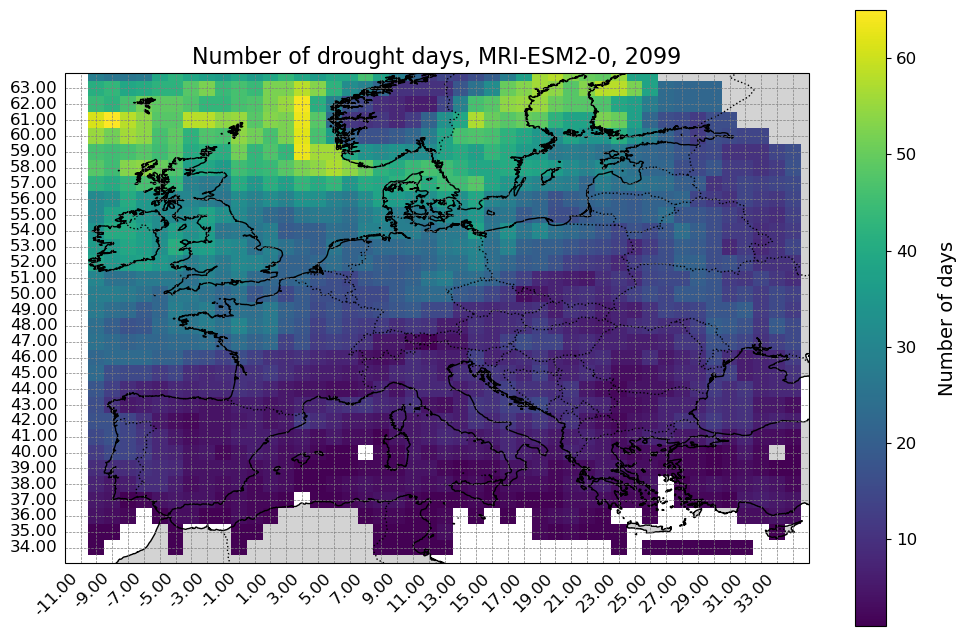

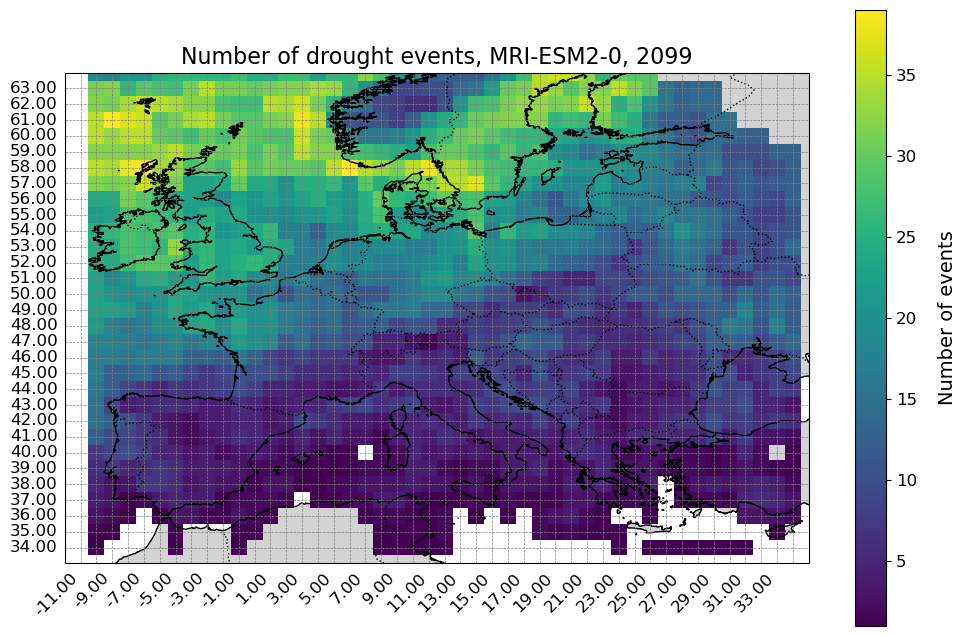

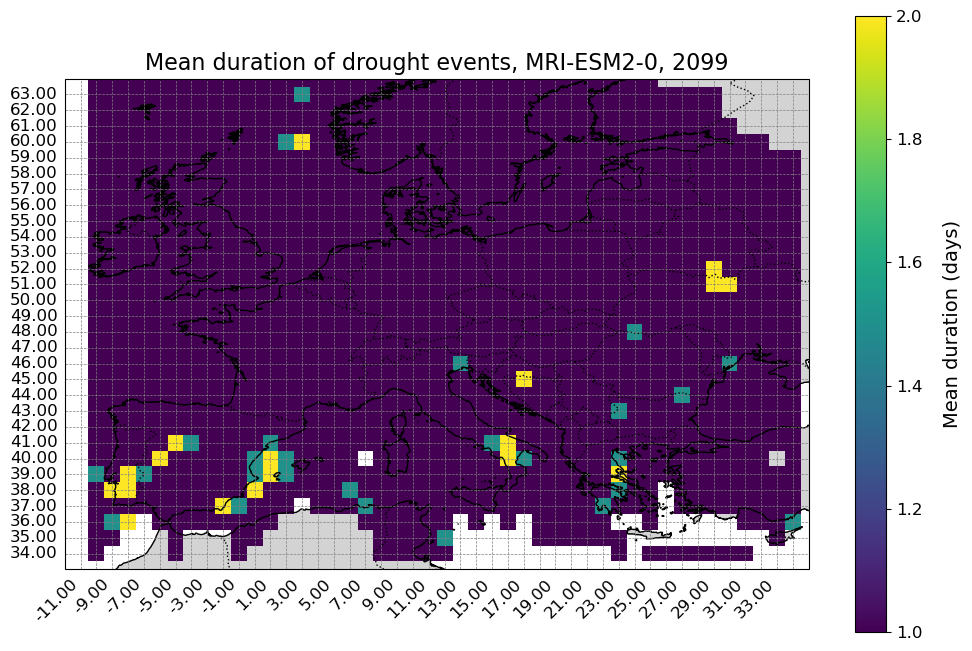

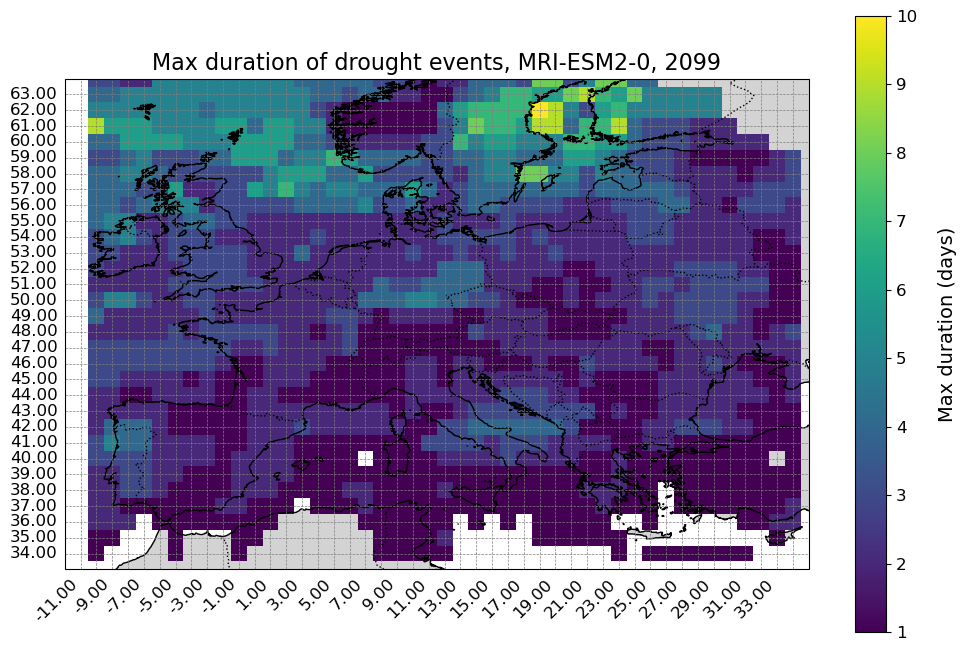

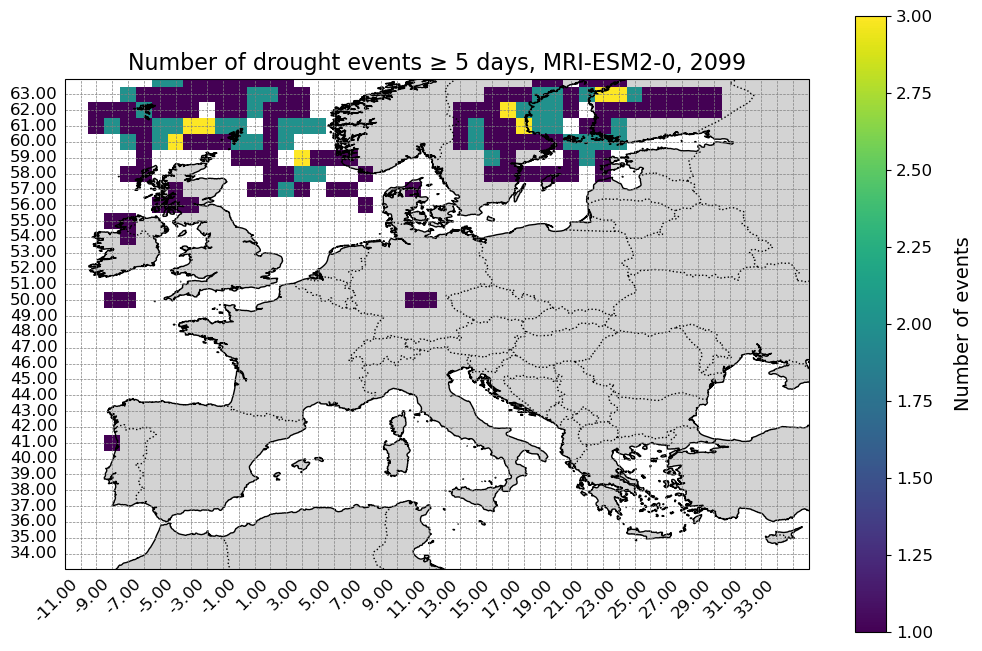

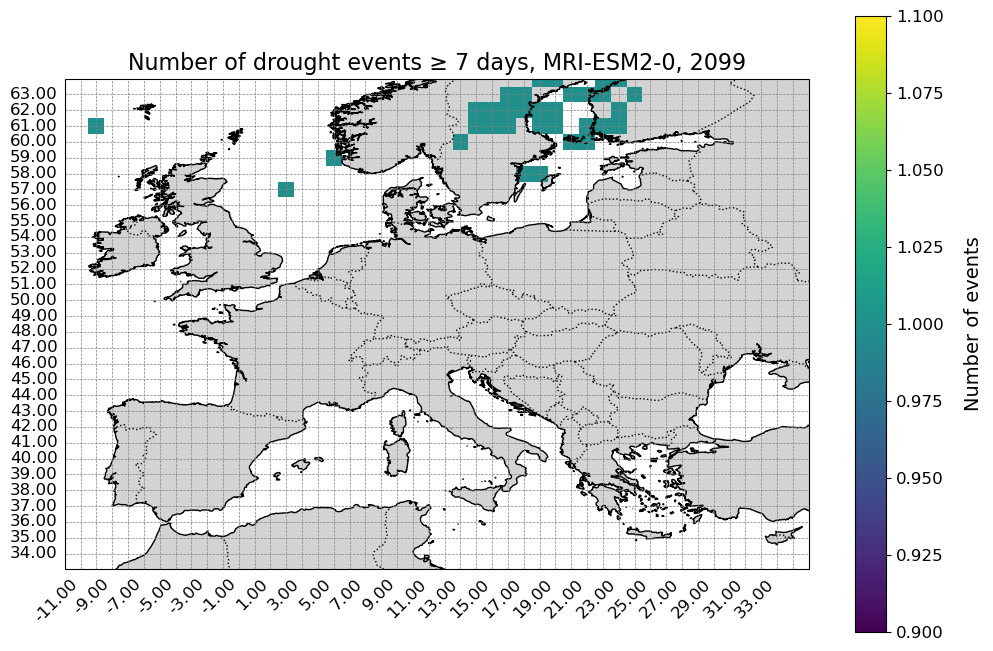

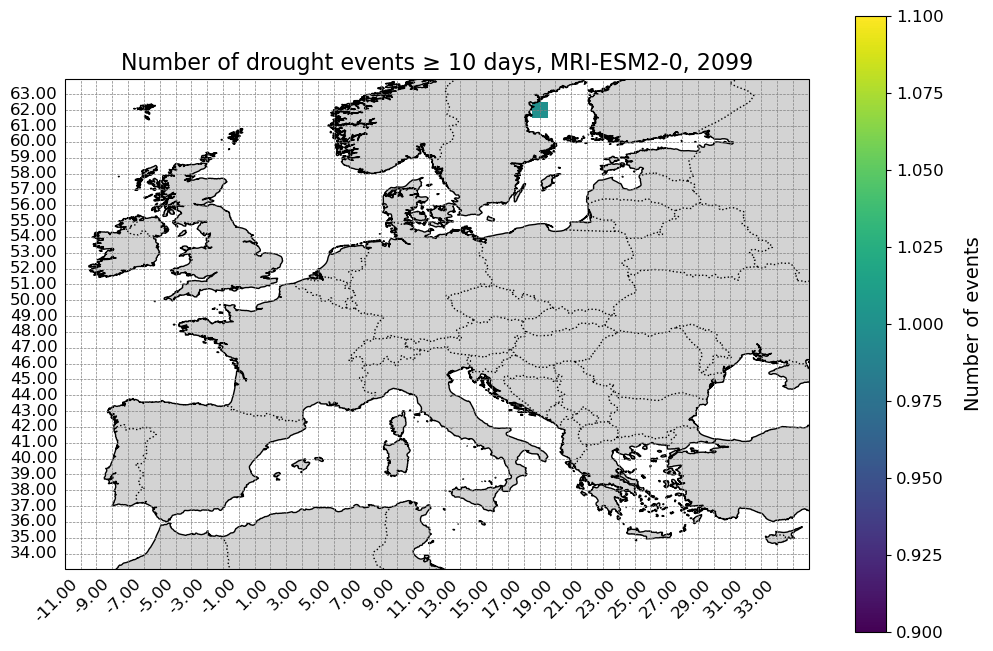

In [101]:
from plots import map_plots
num_drought_days=ds['drought_days']
num_drought_events=ds['drought_events']
median_event_duration=ds['median_event_duration']
max_event_duration=ds['max_event_duration']
events_ge_5d=ds['events_ge_5d']
events_ge_7d=ds['events_ge_7d']
events_ge_10d=ds['events_ge_10d']
map_plots(num_drought_days, cmap='viridis', setnan=True, vmin=None, vmax=None, title='Number of drought days, MRI-ESM2-0, 2099', label='Number of days')
map_plots(num_drought_events, cmap='viridis', setnan=True, vmin=None, vmax=None, title='Number of drought events, MRI-ESM2-0, 2099', label='Number of events')
map_plots(median_event_duration, cmap='viridis', setnan=True, vmin=None, vmax=None, title='Mean duration of drought events, MRI-ESM2-0, 2099', label='Mean duration (days)')
map_plots(max_event_duration, cmap='viridis', setnan=True, vmin=None, vmax=None, title='Max duration of drought events, MRI-ESM2-0, 2099', label='Max duration (days)')
map_plots(events_ge_5d, cmap='viridis', setnan=True, vmin=None, vmax=None, title='Number of drought events ≥ 5 days, MRI-ESM2-0, 2099', label='Number of events')
map_plots(events_ge_7d, cmap='viridis', setnan=True, vmin=None, vmax=None, title='Number of drought events ≥ 7 days, MRI-ESM2-0, 2099', label='Number of events')
map_plots(events_ge_10d, cmap='viridis', setnan=True, vmin=None, vmax=None, title='Number of drought events ≥ 10 days, MRI-ESM2-0, 2099', label='Number of events')


In [ ]:
import glob
import re
#models = ["ACCESS-CM2", "CanESM5", "CMCC-CM2-SR5", "CMCC-ESM2","HadGEM3-GC31-LL", "HadGEM3-GC31-MM", "MRI-ESM2-0"]
for model in models:
    print(f"\n🔍 Aggregating for model: {model}")
    for period, info in periods.items():
        print(f"  ▶ Period: {period}")
        
        base_dir = os.path.join(diri, f"{model}_1x1grid", info['subpath'])
        file_pattern = os.path.join(base_dir, "drought_stats_*.nc")
        drought_files = [ fp for fp in glob.glob(file_pattern) if re.search(r"drought_stats_\d{4}\.nc$", os.path.basename(fp))]

        if not drought_files:
            print(f"  ⚠️ No drought files found for {model} - {period}")
            continue

        # Load all annual drought stats
        datasets = [xr.open_dataset(fp).expand_dims(year=[int(os.path.basename(fp).split("_")[-1].split(".")[0])])
                    for fp in drought_files]

        combined = xr.concat(datasets, dim="year")

        # Median across years (per grid cell)
        median_stats = combined.median(dim="year")

        # Optionally also compute spatial mean over grid for reporting
        spatial_mean = median_stats.mean(dim=['x', 'y'])

        # Save per-model, per-period median map
        median_output_path = os.path.join(base_dir, f"drought_stats_median_{period}.nc")
        median_stats.to_netcdf(median_output_path)
        print(f"  💾 Saved median drought stats for {model} - {period}: {median_output_path}")

        # Print global (spatial) mean summary
        print(f"    ⬩ Spatial mean (model: {model}, period: {period}):")
        for var in spatial_mean.data_vars:
            print(f"      {var}: {spatial_mean[var].item():.2f}")



🔍 Aggregating for model: MRI-ESM2-0
  ▶ Period: BOC
  💾 Saved median drought stats for MRI-ESM2-0 - BOC: /work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/MRI-ESM2-0_1x1grid/historical/drought_stats_median_BOC.nc
    ⬩ Spatial mean (model: MRI-ESM2-0, period: BOC):
      drought_days: 36.93
      drought_events: 25.13
      median_event_duration: 0.73
      max_event_duration: 2.96
      events_ge_5d: 0.38
      events_ge_7d: 0.03
      events_ge_10d: 0.00
  ▶ Period: EOC
  💾 Saved median drought stats for MRI-ESM2-0 - EOC: /work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/MRI-ESM2-0_1x1grid/ssp585/drought_stats_median_EOC.nc
    ⬩ Spatial mean (model: MRI-ESM2-0, period: EOC):
      drought_days: 33.80
      drought_events: 23.43
      median_event_duration: 0.73
      max_event_duration: 2.75
      events_ge_5d: 0.24
      events_ge_7d: 0.01
      events_ge_10d: 0.00


In [ ]:
file_BOC="/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/MRI-ESM2_1x1grid/historical/drought_stats_median_BOC.nc"
file_EOC="/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/MRI-ESM2_1x1grid/ssp585/drought_stats_median_EOC.nc"
ds_BOC=xr.open_dataset(file_BOC, engine="netcdf4")
ds_EOC=xr.open_dataset(file_EOC, engine="netcdf4")

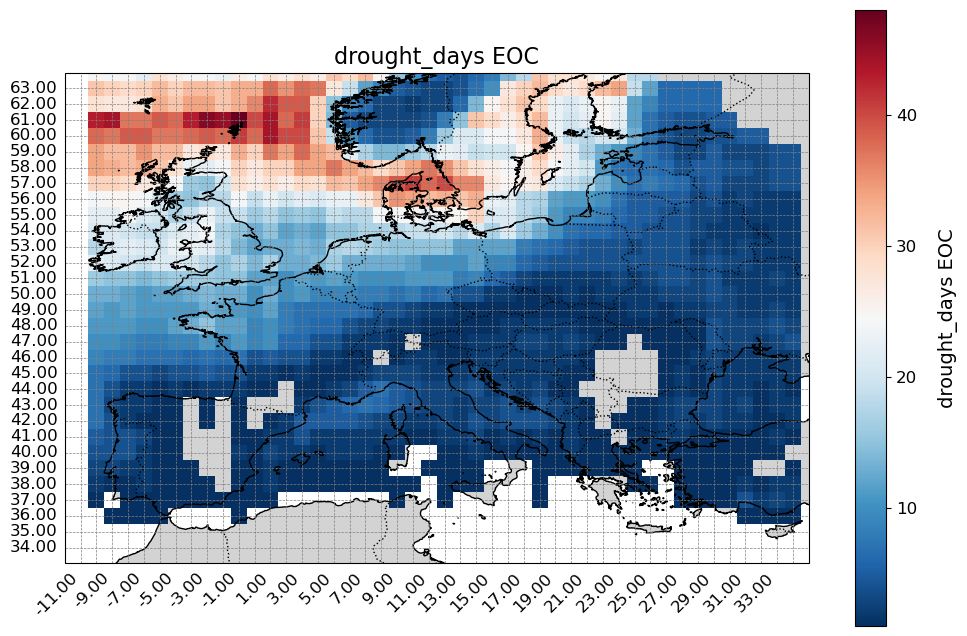

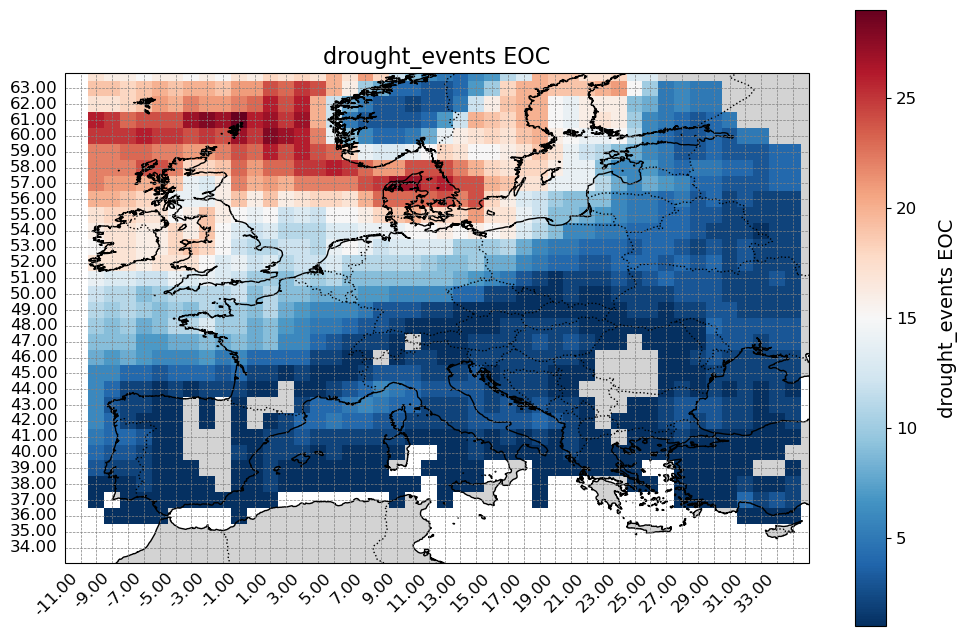

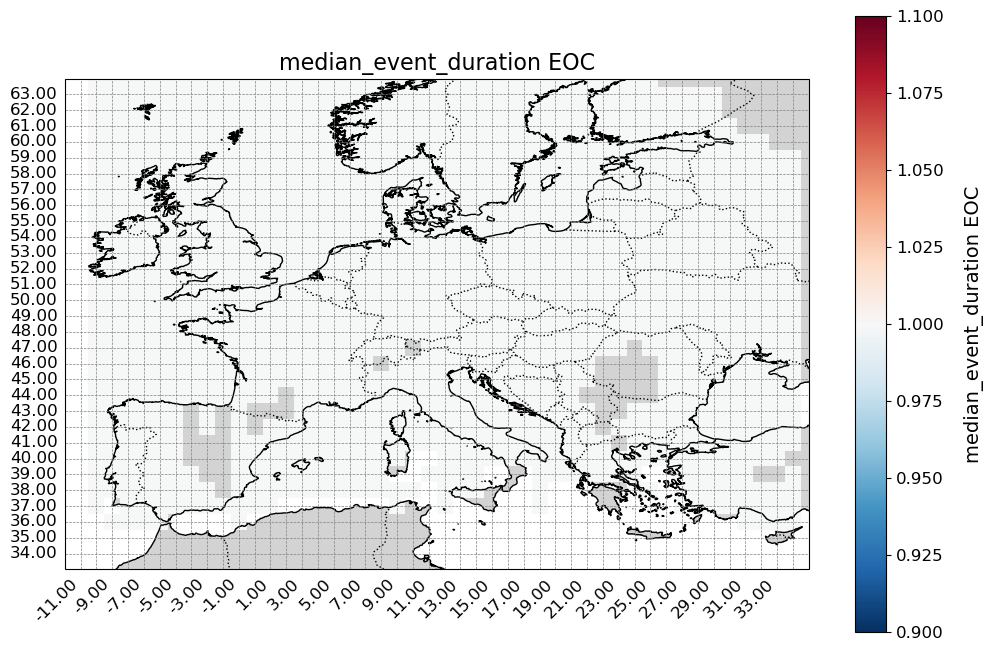

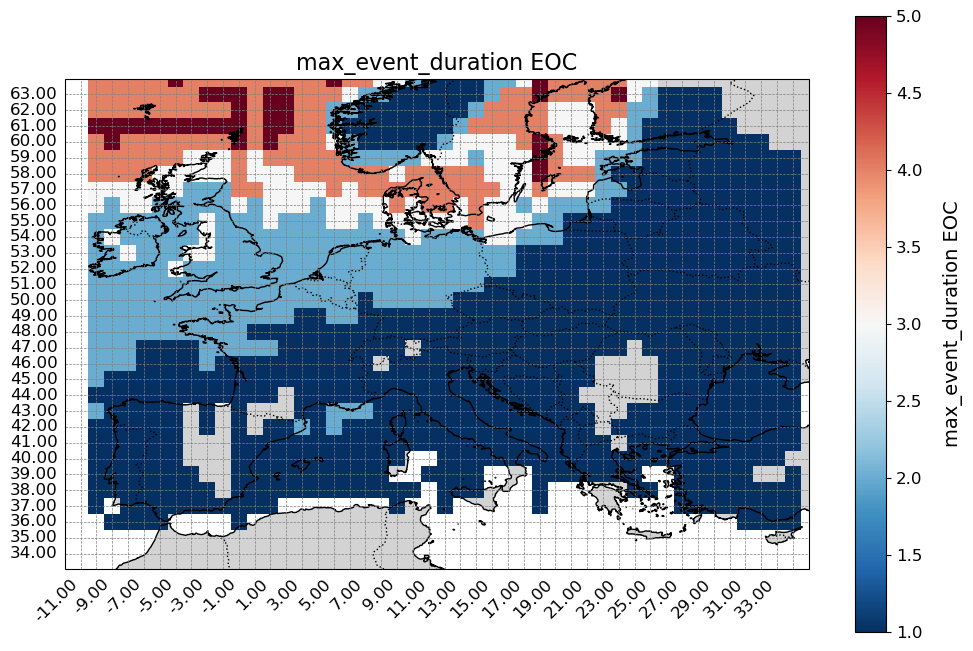

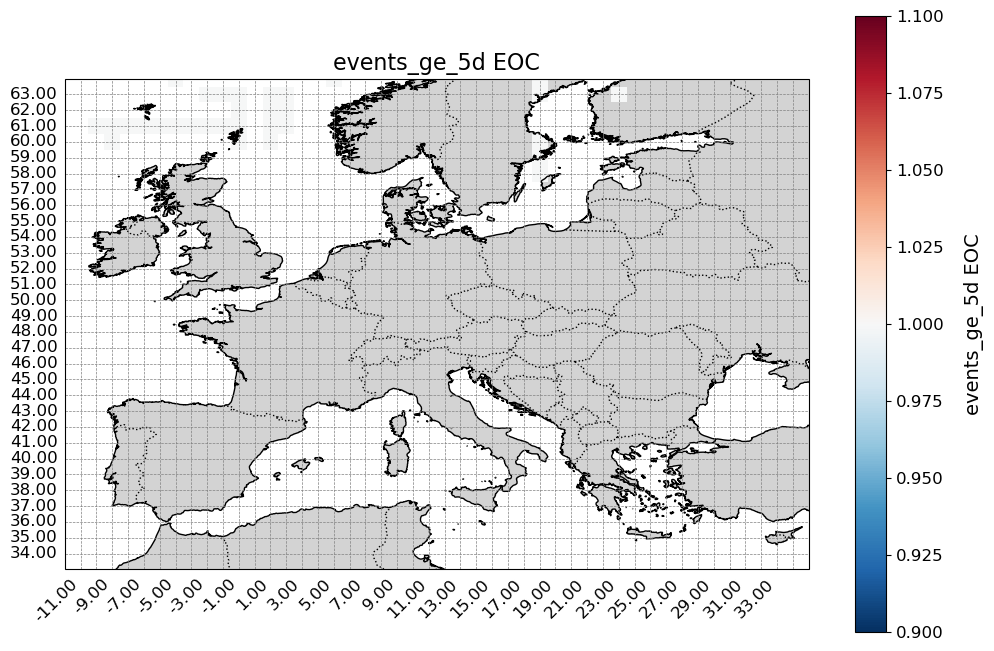

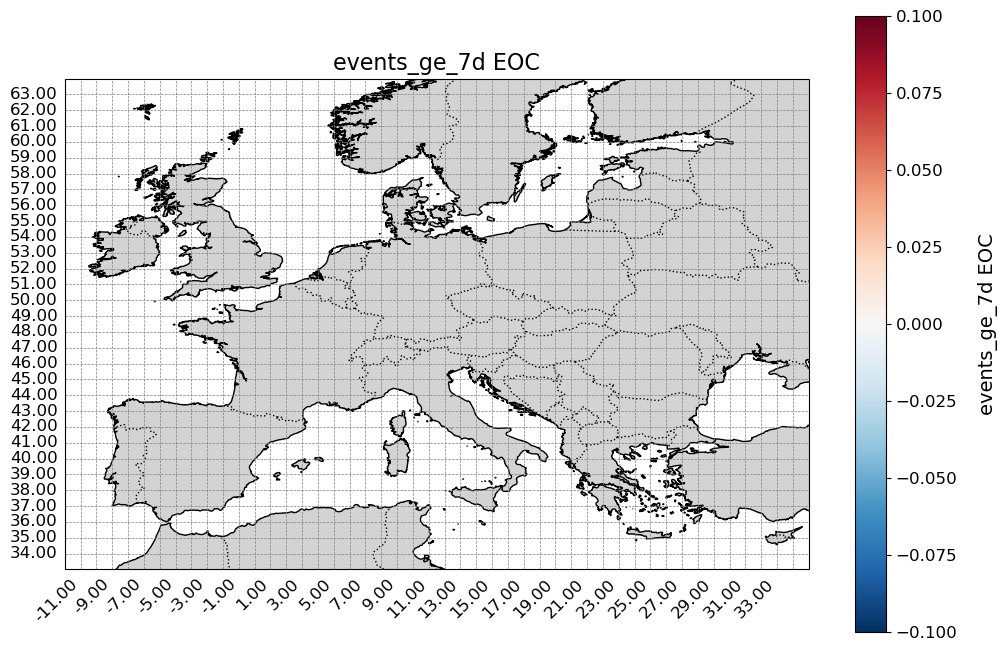

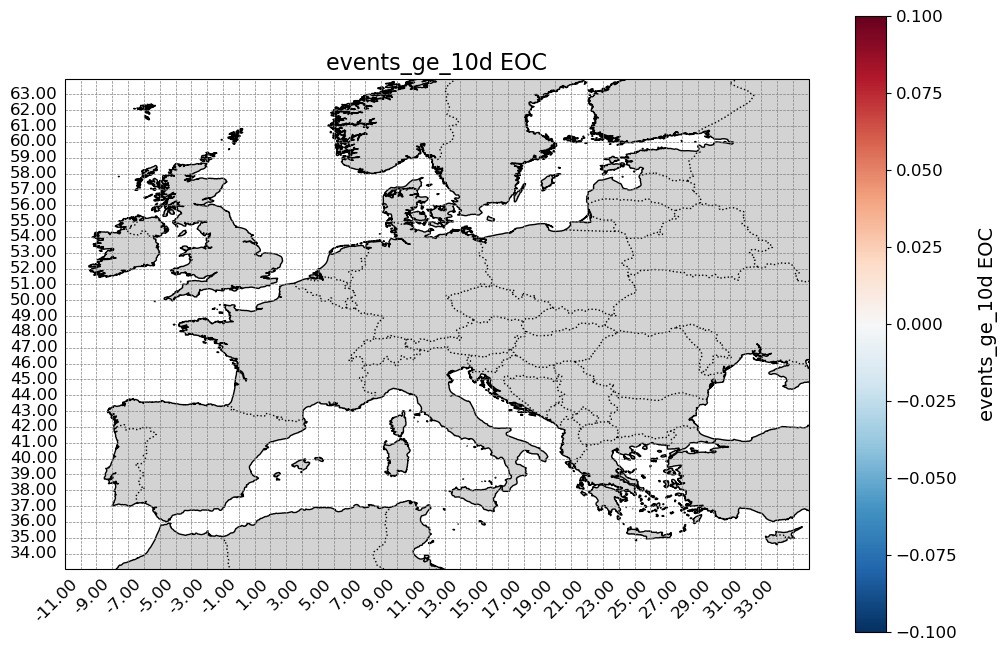

In [89]:
for var in ds_EOC.data_vars:
    map_plots(
        ds_EOC[var], 
        cmap='RdBu_r', 
        setnan=True, 
        vmin=None, 
        vmax=None, 
        title=f"{var} EOC", 
        label=f"{var} EOC"
    )

In [90]:
ds_diff = ds_EOC - ds_BOC
threshold_Nan = 1e-10
ds_diff = ds_diff.where(np.abs(ds_diff) > threshold_Nan, 0)

In [91]:
print(ds_diff)
print(ds_diff['drought_days'].mean().item(), "avg change in drought days")
print(ds_diff['drought_events'].mean().item(), "avg change in event count")


<xarray.Dataset> Size: 109kB
Dimensions:                (y: 40, x: 48)
Coordinates:
  * x                      (x) float64 384B -12.0 -11.0 -10.0 ... 33.0 34.0 35.0
    lon                    (x) float64 384B -12.0 -11.0 -10.0 ... 33.0 34.0 35.0
  * y                      (y) float64 320B 33.0 34.0 35.0 ... 70.0 71.0 72.0
    lat                    (y) float64 320B 33.0 34.0 35.0 ... 70.0 71.0 72.0
Data variables:
    drought_days           (y, x) float64 15kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    drought_events         (y, x) float64 15kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    median_event_duration  (y, x) float64 15kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    max_event_duration     (y, x) float64 15kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    events_ge_5d           (y, x) float64 15kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    events_ge_7d           (y, x) float64 15kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    events_ge_10d          (y, x) float64 15kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
1.0682291666666666 avg change

In [68]:
ds_BOC['events_ge_7d'].max().item(), ds_EOC['events_ge_7d'].max().item()


(0.0, 0.0)

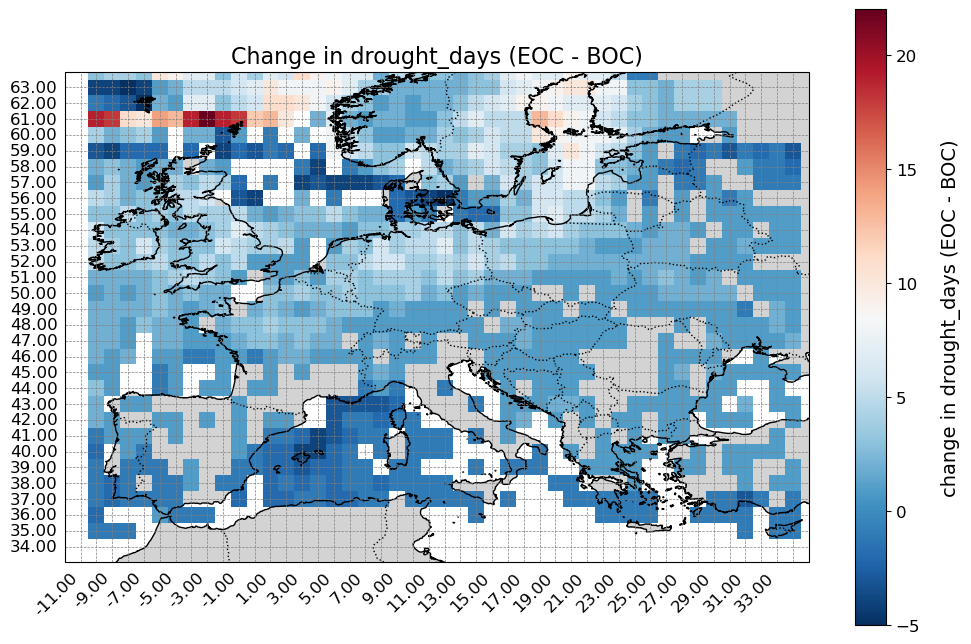

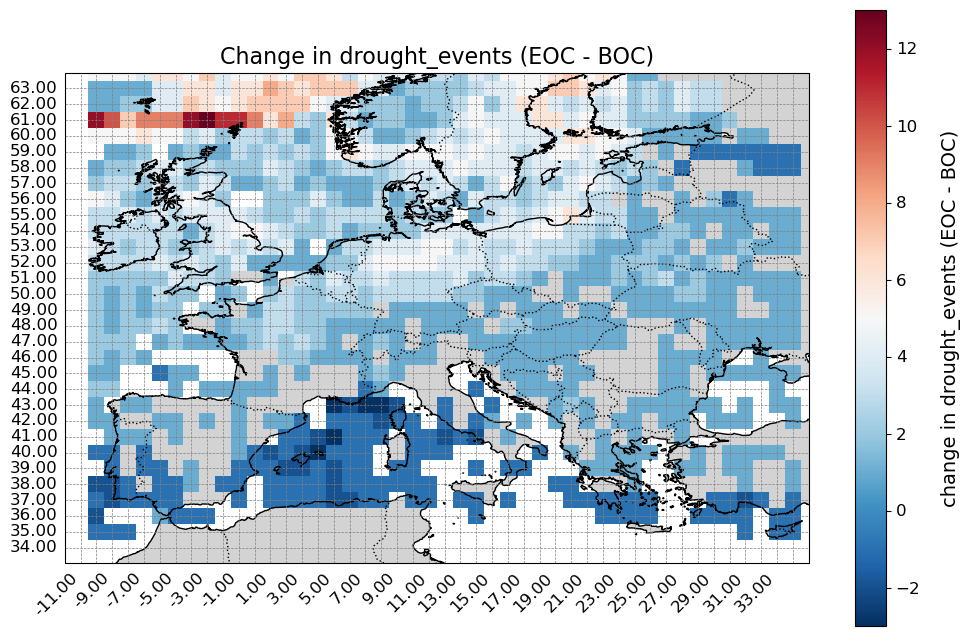

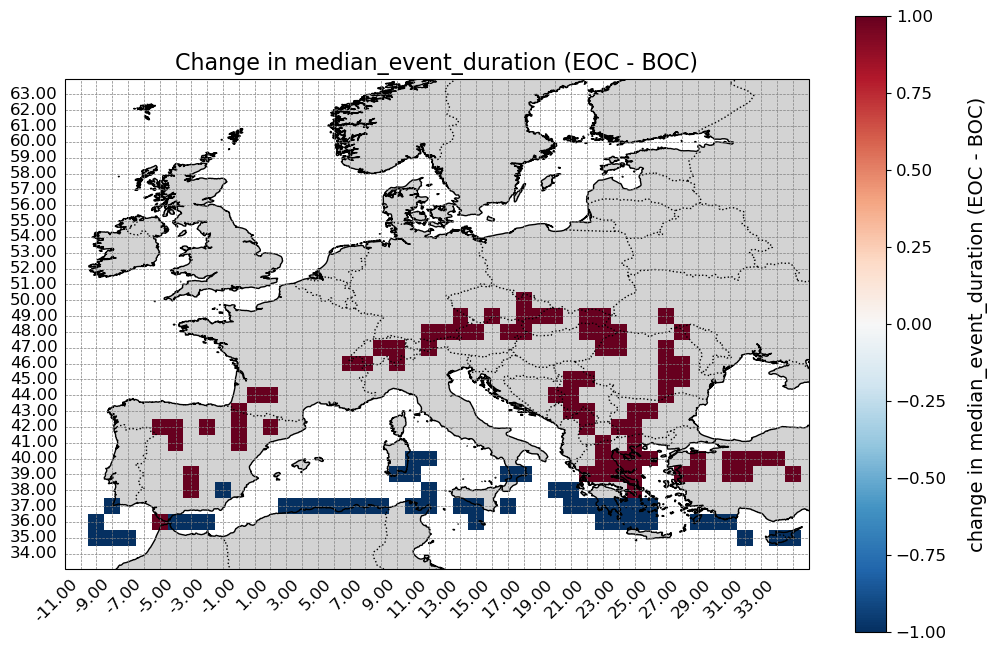

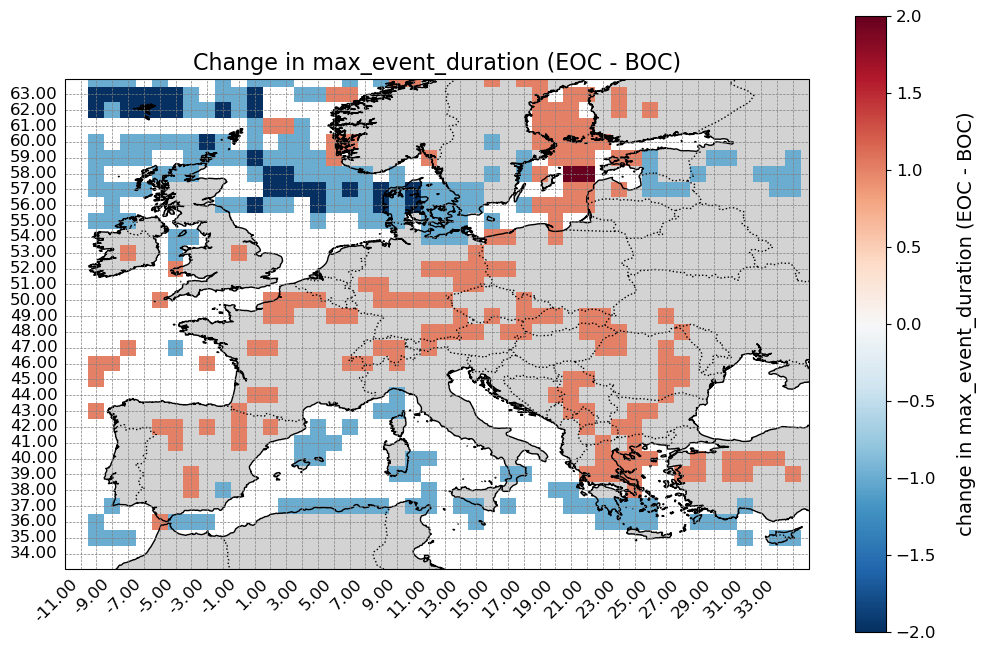

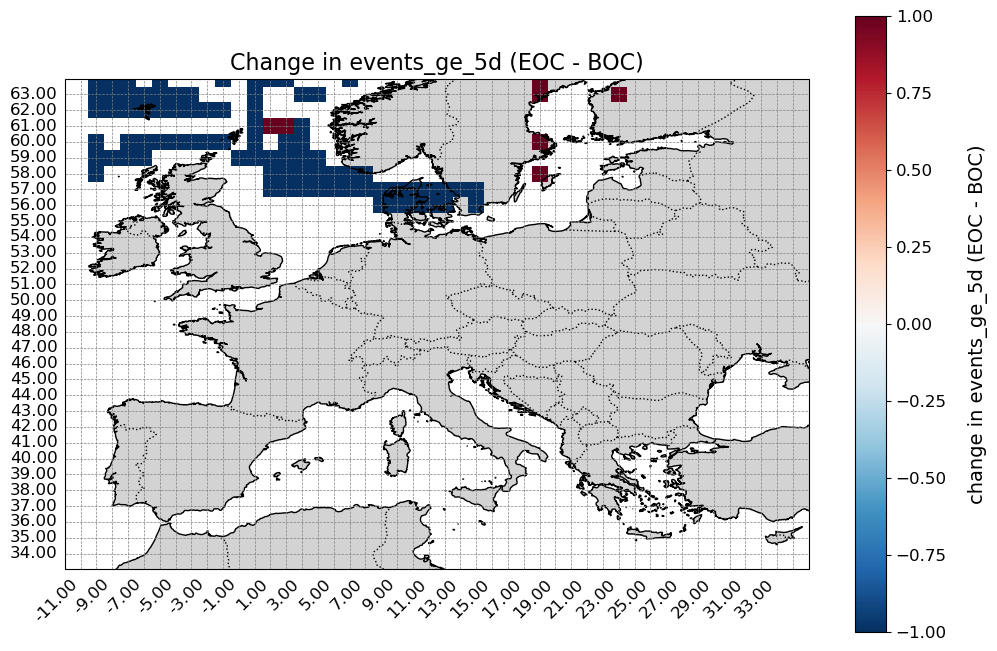

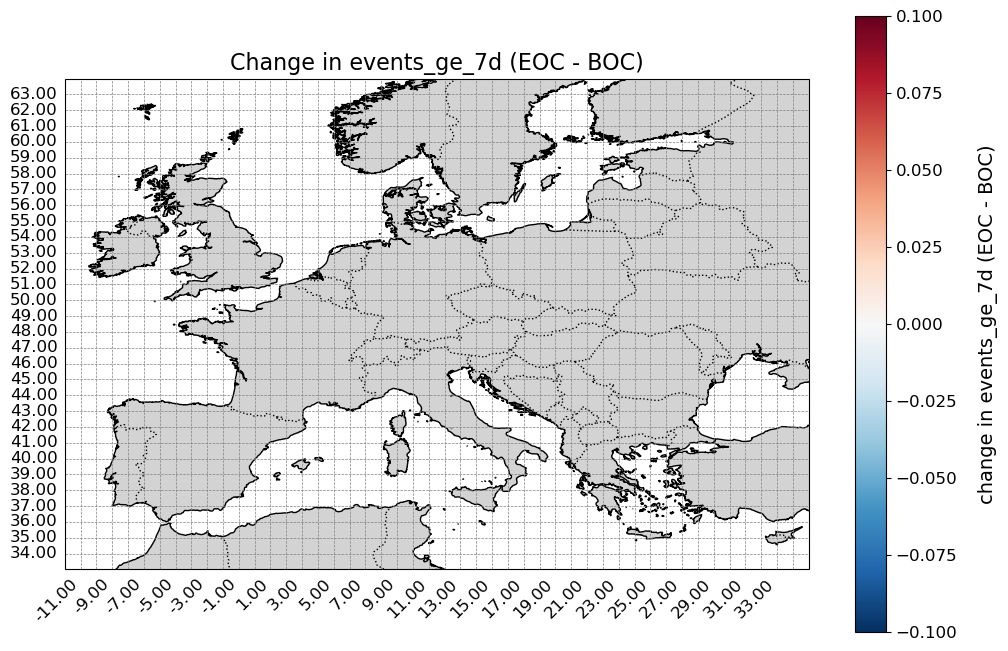

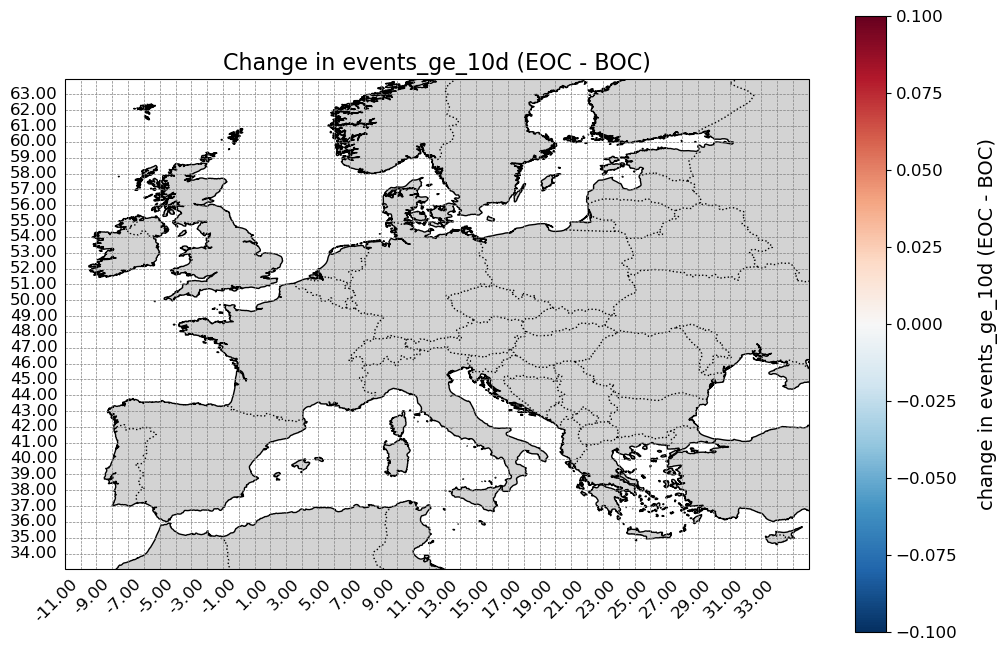

In [92]:
import matplotlib.pyplot as plt

for var in ds_diff.data_vars:
    map_plots(
        ds_diff[var], 
        cmap='RdBu_r', 
        setnan=True, 
        vmin=None, 
        vmax=None, 
        title=f"Change in {var} (EOC - BOC)", 
        label=f"change in {var} (EOC - BOC)"
    )


In [93]:
#trying to understand where are the Nans coming from
print(weekly_clim.isnull().sum(dim='weekofyear'))  # NaNs per pixel


<xarray.DataArray 'specific generation' (y: 40, x: 48)> Size: 15kB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * x        (x) float64 384B -12.0 -11.0 -10.0 -9.0 ... 32.0 33.0 34.0 35.0
    lon      (x) float64 384B ...
  * y        (y) float64 320B 33.0 34.0 35.0 36.0 37.0 ... 69.0 70.0 71.0 72.0
    lat      (y) float64 320B ...


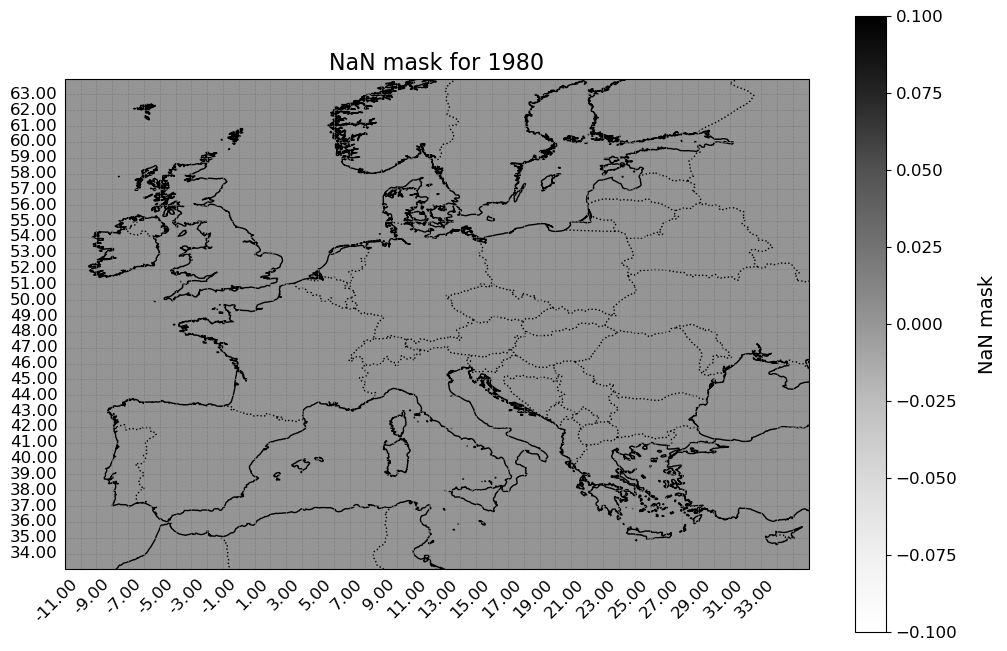

In [94]:
ds = xr.open_dataset("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/ACCESS-CM2_1x1grid/historical/daily_solar_power_1980.nc")
mask = ds['specific generation'].isnull().any(dim='time')
map_plots(mask, cmap='Greys', setnan=False, vmin=None, vmax=None, title='NaN mask for 1980', label='NaN mask')
